#GAN with LGBM as classifier

## Importing Libraries

In [ ]:
import os
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix,roc_auc_score,average_precision_score
from lightgbm import LGBMClassifier

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


## EDA

In [ ]:
df=pd.read_csv('./creditcard.csv')
df=df.drop('Time',axis=1)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

PCA Transformation: The description of the data says that all the features went through a PCA transformation (Except for time and amount).  
Scaling: Keep in mind that in order to implement a PCA transformation features need to be previously scaled.

In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# checking for duplicate values
print(f"Dataset has {df.duplicated().sum()} duplicate rows")
# dropping duplicate rows
df.drop_duplicates(inplace=True)

Dataset has 9144 duplicate rows


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 18  V19     275663 non-null  float64
 19  V20     275663 non-null  float64
 20  V21     275663 non-null  float64
 21  V22     275663 

There is no null values

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


<Axes: xlabel='Class', ylabel='count'>

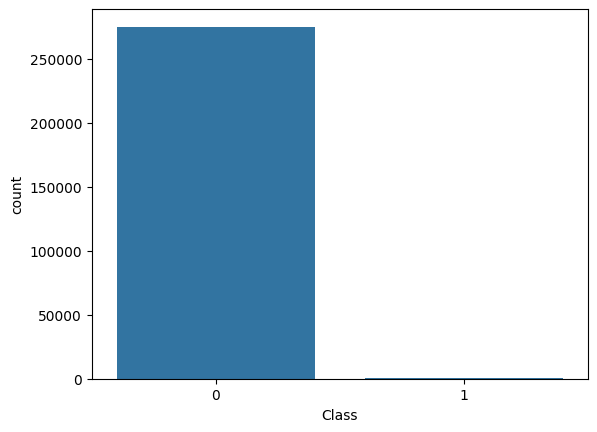

In [ ]:
sns.countplot(data=df,x='Class')

In [ ]:
df.drop('Class',axis=1).skew()

,0
V1,-3.273070
V2,-4.653486
V3,-2.216730
V4,0.681387
V5,-2.458790
V6,1.867576
V7,2.877722
V8,-8.292631
V9,0.550965
V10,1.242165


<Axes: xlabel='Amount', ylabel='Density'>

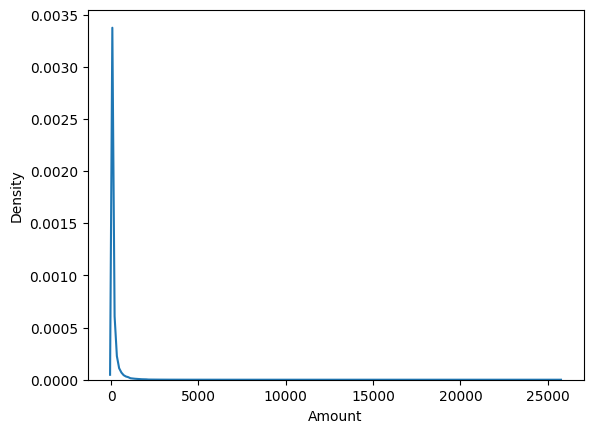

In [ ]:
sns.kdeplot(df['Amount'])

<Axes: xlabel='Amount', ylabel='Density'>

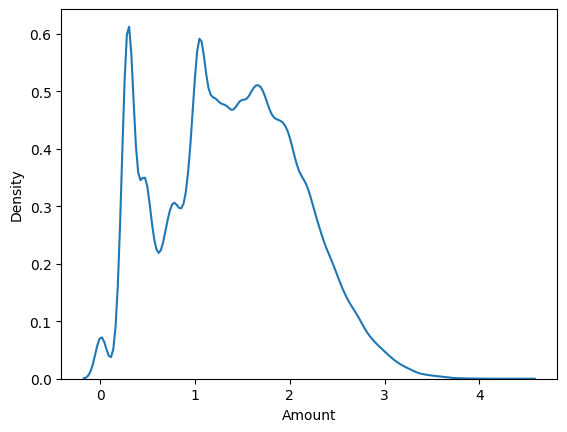

In [ ]:
df['Amount'] = df['Amount'].apply(lambda x: np.log10(x+1))
sns.kdeplot(df['Amount'])

## Creating a sub sample

What - create a[](http://) df with equal number of fraud and non fraud samples  
Why - Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the target. By having an imbalance dataframe we are not able to see the true correlations between the class and features

In [ ]:
df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

subsample = pd.concat([fraud_df, non_fraud_df])
new_df = subsample.sample(frac=1, random_state=42)

### Correlation

In [ ]:
corr = df.corr()
fig=px.imshow(corr, aspect="auto" ,color_continuous_scale='RdBu_r')
fig.show()

In [ ]:
corr = new_df.corr()
fig=px.imshow(corr, aspect="auto" ,color_continuous_scale='RdBu_r')
fig.show()

Negative Correlations: V17, V14, V12 and V10 are negatively correlated.  
Positive Correlations: V2, V4, V11 are positively correlated.

Note-Used chatgpt to understand the correlations. As the features are anonymised it was difficult to conclude and get relationship and dependency on eachother.

Reference-https://data36.com/correlation-definition-calculation-corr-pandas/

In [ ]:
# Calculate absolute correlation matrix (optional: choose df or new_df)
corr_matrix = new_df.corr().abs()

# Select upper triangle of correlation matrix to avoid duplicates and self-correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Set threshold
threshold = 0.9

# Find feature pairs with high correlation
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2])
                   for col1 in upper.columns
                   for col2 in upper.columns
                   if (upper.loc[col1, col2] > threshold)]

# Display results
print("Highly Correlated Feature Pairs (|r| > 0.9):")
for f1, f2, corr_value in high_corr_pairs:
    print(f"{f1} ↔ {f2}: r = {corr_value:.2f}")

Highly Correlated Feature Pairs (|r| > 0.9):
V16 ↔ V17: r = 0.95
V16 ↔ V18: r = 0.91
V17 ↔ V18: r = 0.94


### TSNE

In [ ]:
from sklearn.manifold import TSNE
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# T-SNE Implementation
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

In [ ]:
fig=px.scatter(x=X_reduced_tsne[:,0], y=X_reduced_tsne[:,1], color=y)
fig.show()

Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately

Reference- https://www.geeksforgeeks.org/machine-learning/difference-between-pca-vs-t-sne/

Note-ChatGPT was used to help understand the results using WebSearch Feature.

## Scaling

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values
print(X.shape, y.shape)

(275663, 29) (275663,)


## Splitting the data

we want to test our models on the original testing set not on the testing set created from GAN. The main goal is to fit the model in the generated data, and test it on the original testing set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Testing baseline model with original data

# GAN

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
import tensorflow as tf

class GAN():
    def __init__(self):

        self.latent_dim = 32
        self.out_shape = 29


        self.optimizer = Adam(0.0002, 0.5)

        # Build and compile discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss='binary_crossentropy',
            optimizer=self.optimizer,
            metrics=['accuracy'],
            run_eagerly=True  # Enable eager execution for the discriminator
        )

        # Build generator
        self.generator = self.build_generator()


    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        output = model(noise)
        return Model(noise, output)

    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Dense(512, input_dim=self.out_shape))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=(self.out_shape,))
        validity = model(img)
        return Model(img, validity)

    def train(self, X_train, y_train, pos_index, neg_index, epochs, batch_size=32, sample_interval=50):

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # ---------------------
            #  Train Discriminator
            # ---------------------
            idx_pos = np.random.choice(pos_index, 8)
            idx_neg = np.random.choice(neg_index, batch_size - 8)
            idx = np.concatenate([idx_pos, idx_neg])
            real_samples = X_train[idx]
            real_samples, _ = shuffle(real_samples, y_train[idx])

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict(noise)

            if epoch < epochs / 1.5:
                valid_smooth = (valid + 0.1) - (np.random.random(valid.shape) * 0.1)
                fake_smooth = (fake - 0.1) + (np.random.random(fake.shape) * 0.1)
            else:
                valid_smooth = valid
                fake_smooth = fake

            self.discriminator.trainable = True
            d_real_loss, d_real_acc = self.discriminator.train_on_batch(real_samples, valid_smooth)
            d_fake_loss, d_fake_acc = self.discriminator.train_on_batch(gen_samples, fake_smooth)
            d_loss = [0.5 * (d_real_loss + d_fake_loss), 0.5 * (d_real_acc + d_fake_acc)]

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = Input(shape=(self.latent_dim,))
            generated = self.generator(noise)
            self.discriminator.trainable = False
            validity = self.discriminator(generated)
            self.combined = Model(noise, validity)
            self.combined.compile(
                loss='binary_crossentropy',
                optimizer=Adam(0.0002, 0.5), # Recreate optimizer for combined model
                metrics=['accuracy'],
                run_eagerly=True
            )

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss, g_acc = self.combined.train_on_batch(noise, valid)

            # Print the progress
            if (epoch + 1) % sample_interval == 0:
                print(f"Epoch {epoch + 1}/{epochs} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")



In [ ]:
gan = GAN()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,713 (702.00 KB)

 Trainable params: 179,713 (702.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,293 (731.61 KB)

 Trainable params: 185,501 (724.61 KB)

 Non-trainable params: 1,792 (7.00 KB)

#Training GAN

In [ ]:
y_train = y_train.reshape(-1, 1)
pos_index = np.where(y_train == 1)[0]
neg_index = np.where(y_train == 0)[0]
gan.train(X_train, y_train, pos_index, neg_index, epochs=1000)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

#Generating new samples

In [ ]:
# 1. Sample noise for only‐fraud synthetic data
noise = np.random.normal(0, 1, (250_000, gan.latent_dim))

# 2. Generate synthetic samples
gen_samples = gan.generator.predict(noise, verbose=0)


In [ ]:
# 3. Invert your scaler to get back to original feature space
gen_samples = scaler.inverse_transform(gen_samples)
print("Synthetic shape:", gen_samples.shape)



Synthetic shape: (250000, 29)


In [ ]:
# 4. Turn into a DataFrame (optional, for inspection)
gen_df = pd.DataFrame(gen_samples, columns=df.drop('Class', axis=1).columns)
print(gen_df.head())



         V1        V2        V3        V4        V5        V6        V7  \
0 -1.972118 -1.669687 -1.478536 -1.428680  0.020501  1.298988 -1.231760   
1  0.784032 -1.661718  1.532952 -1.428677  0.030886 -1.315562 -1.231263   
2 -1.984728  0.510876 -0.351755 -1.323283  1.359916  1.256254 -0.704163   
3 -1.751969  1.663813 -0.049217  1.419278  1.361775 -0.030008  1.248727   
4 -1.633736 -1.595790  1.532221 -1.302292 -1.335402  1.296398 -0.814927   

         V8        V9       V10  ...       V20       V21       V22       V23  \
0  1.082339 -0.883867 -1.065972  ...  0.750464  0.731676  0.732194  0.608347   
1  0.746213 -0.660118 -0.999783  ...  0.598885 -0.725191 -0.719414  0.569090   
2  1.023788 -0.973978 -1.001391  ...  0.613083  0.691489  0.731072 -0.425505   
3  0.283495  0.997580 -0.912581  ...  0.273022 -0.670327 -0.720543  0.621542   
4  0.527142  0.821156  0.501257  ...  0.758744  0.674908  0.701580  0.578306   

        V24       V25       V26       V27       V28    Amount  
0 -0

In [ ]:
# 5. Append to your real training set
gen_X_train = np.vstack([X_train, gen_samples])
print("Augmented X shape:", gen_X_train.shape)



Augmented X shape: (470530, 29)


In [ ]:
# 6. Create corresponding labels (all 1s for fraud) and append
gen_y = np.ones((250_000, 1), dtype='int32')
# make sure y_train is also shape (n,1)
y_train = y_train.reshape(-1,1)
gen_y_train = np.vstack([y_train, gen_y])
print("Augmented y shape:", gen_y_train.shape)

Augmented y shape: (470530, 1)


## Testing baseline model with generated data

Augmented y_train shape: (470530, 1)
[LightGBM] [Info] Number of positive: 250378, number of negative: 220152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 470530, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532119 -> initscore=0.128654
[LightGBM] [Info] Start training from score 0.128654


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names




ROC-AUC: 0.9560
PR-AUC:  0.7411



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names




Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.82      0.78      0.80        95

    accuracy                           1.00     55133
   macro avg       0.91      0.89      0.90     55133
weighted avg       1.00      1.00      1.00     55133

Confusion Matrix:
 [[55022    16]
 [   21    74]]


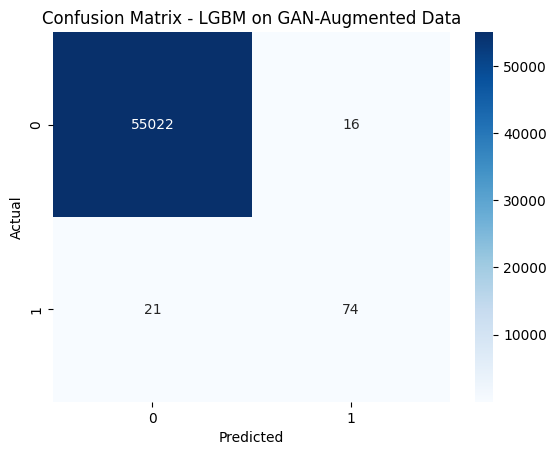

In [ ]:
n_synth=250_000
#Augment training labels: Generated fraud data → label 1
gen_y = np.ones((n_synth, 1), dtype='int32')
y_train = y_train.reshape(-1, 1)  # Ensure y_train has shape (n, 1)
gen_y_train = np.vstack([y_train, gen_y])
print("Augmented y_train shape:", gen_y_train.shape)

#Train a classifier on augmented dataset
clf = LGBMClassifier()
clf.fit(gen_X_train, gen_y_train.ravel())

# Predict on REAL hold-out + metrics (ROC-AUC & PR-AUC) ---
y_prob = clf.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

roc = roc_auc_score(y_test, y_prob)
pr  = average_precision_score(y_test, y_prob)

print(f"\nROC-AUC: {roc:.4f}")
print(f"PR-AUC:  {pr:.4f}\n")

# Predict and evaluate on test set
y_pred = clf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optional: Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LGBM on GAN-Augmented Data')
plt.show()


Referneces-[A hybrid deep learning approach with generative adversarial network for credit card fraud detection](https://doi.org/10.3390/technologies12100186), [Improving detection of credit card fraudulent transactions using generative adversarial networks](https://arxiv.org/abs/1907.03355), [Generative adversarial networks-based novel approach for fraud detection for the European Cardholders 2013 dataset](https://doi.org/10.1109/ACCESS.2023.3320072)

Note- ChatGPT used for understanding results .